<a href="https://colab.research.google.com/github/QuinnGrace/StatML4PopHealth/blob/changes/lectures/day2/lecture7/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning
for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

# Gaussian Process Regression with Stan

## Objectives
In this tutorial, you will learn about how to implement a Gaussian Process (GP) in Stan.

By the end of this tutorial,
1. You will have a better understanding of implementing custom functions in Stan;
2. You will improve your ability to translate mathematics into Stan code;
3. You will have a better understanding of GPs and how to implement them in probabilistic programming languages.

## Flow of the tutorial
1. Brief description of the dataset
2. Review of Gaussian Processes
3. How to implement a GP in Stan

In [1]:
# Install CmdStanPy for Google Colab
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/scripts/utilities.py"
from utilities import custom_install_cmdstan, test_cmdstan_installation
custom_install_cmdstan()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2066  100  2066    0     0   8290      0 --:--:-- --:--:-- --:--:--  8297
Installing cmdstanpy==1.2.5
Unpacking colab-cmdstan-2.36.0.tar.gz
Installing required libtbb2 Linux package
Setting cmdstan path
CmdStan successfully installed!


In [2]:
# Import required packages
import numpy as np
import pandas as pd

from cmdstanpy import CmdStanModel
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

# Aesthetics
sns.set_theme(style='whitegrid')
plt.rc('font', size=9)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=9)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('legend', fontsize=9)

## The dataset
For this tutorial, we will use the `nile` dataset available via the `statsmodels` library. The dataset consists of annual flow measurements of the Nile River at Aswan from 1871 to 1970.

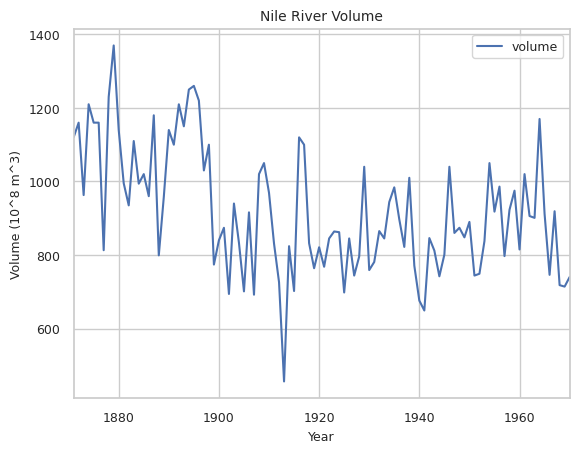

In [3]:
from statsmodels.datasets import nile
nile = nile.load_pandas().data

# Plot the data
fig, ax = plt.subplots()
nile.plot(x='year', y='volume', ax=ax)
ax.set_title('Nile River Volume')
ax.set_xlabel('Year')
ax.set_ylabel('Volume (10^8 m^3)')
ax.set_xlim(1871, 1970)
plt.show()

### Data preprocessing
To make things easier for the model, we will normalise the year data to be between 0 and 1 and standardise the flow data to have a mean of 0 and a standard deviation of 1.

In [4]:
volume = nile['volume'].values
year = nile['year'].values

# Standardise year
year_mean = year.mean()
year_std = year.std()
x = (year - year_mean) / year_std

# Standardise volume
volume_mean = volume.mean()
volume_std = volume.std()
y = (volume - volume_mean) / volume_std

print(x.shape, y.shape)

(100,) (100,)


## Review of Gaussian Process Regression

Let $\mathbf{y} = (y_1,\ldots,y_n)^\top$ be a vector of outcomes, in this case flow volume. Let $\mathbf{x} = (x_1,\ldots,x_n)^\top$ be a vector of inputs, in this case year. We will model the data as
$$
\begin{align*}
\mathbf{y} &= \alpha + f(\mathbf{x}) + \boldsymbol{\varepsilon}, \\
f(\mathbf{x}) &\sim GP(m(\mathbf{x}), k(\mathbf{x},\mathbf{x}')), \\
\boldsymbol{\varepsilon} &\sim N(0, \sigma_{\varepsilon}^2\mathbf{I}_n),
\end{align*}
$$
where $m(\mathbf{x})$ is the mean function, $k(\mathbf{x},\mathbf{x}')$ is the covariance function, and $\sigma_{\varepsilon}^2$ is the noise variance. For simplicity, we will assume that $m(\mathbf{x}) = 0$
$$
f(\mathbf{x}) \sim GP(0, k(\mathbf{x},\mathbf{x}')).
$$

Recall that for finite data, the zero mean GP prior is a multivariate Gaussian distribution with mean vector $\mathbf{0}$ and covariance matrix $\mathbf{K}$, where $K_{ij} = k(x_i,x_j)$.
$$
\mathbf{K} = \begin{pmatrix}
k(x_1,x_1) & \cdots & k(x_1,x_n) \\
\vdots & \ddots & \vdots \\
k(x_n,x_1) & \cdots & k(x_n,x_n)
\end{pmatrix}.
$$

The function $k$ is referred to as a covariance function or kernel function. Common choices for the kernel function include the squared exponential kernel, the Matern kernel, and the periodic kernel. As we shall see later, the choice of kernel characterises the smoothness of the GP. If, for example, we chose the squared exponential kernel, then $k$ has the form
$$
k(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\ell^2}\right),
$$
where $\sigma^2$ is the marginal variance and $\ell$ is the lengthscale.

To sample from a GP, we first compute the covariance matrix $\mathbf{K}$ for a given set of inputs $\mathbf{x}$, kernel $k$, and hyperparameters. We then perform the Cholesky decomposition of $\mathbf{K}$ such that
$$
\mathbf{K} = \mathbf{L}\mathbf{L}^\top,
$$
where $\mathbf{L}$ is a lower triangular matrix. We then sample an auxiliary vector $\mathbf{z}$ from a standard multivariate normal distribution, i.e., $\mathbf{z} \sim N(\mathbf{0},\mathbf{I}_n)$. Finally, we compute the GP sample as
$$
\mathbf{f} = \mathbf{L}\mathbf{z}.
$$

### The nugget effect
When you implement GPs in any numerical library, you need to add a small constant (e.g., $10^{-6}$) to diagonal of the covariance matrix to make sure that the matrix is positive definite. This is called the nugget effect.
$$
\mathbf{K}_{\text{nugget}} = \mathbf{K} + 10^{-6} \times \mathbf{I}_n.
$$

## Implementing a GP in Stan

### The GP prior
To keep the code in the other blocks clean, we will define the GP prior in the `functions` block. We will write a custom function named `gp_se` that takes in the input points `x`, the marginal variance `alpha`, and the lengthscale `ell`, and a vector of auxiliary variables `z`. The function will return the GP sample `f`. The code will look something like this:

```stan
functions {
    vector gp_se(vector x, real sigma, real ell, vector z) {
        int n = rows(x);
        matrix[n,n] K;
        vector[n] f;
        matrix[n,n] L;

        // 1. Compute the covariance matrix (don't forget to add the nuggget term)


        K = matrix gp_matern52_cov(x, sigma, ell);
        K = K + diag_matrix(rep_vector(1e-6,n));

        // 2. Perform the Cholesky decomposition

        L = cholesky_decompose(K);

        // 3. Compute the GP sample
        f = L * z;

        return f;
    }
}
```

Your task is to fill in the missing parts of the code. Refer to the [Stan Functions Reference](https://mc-stan.org/docs/functions-reference/index.html) on how to compute the covariance matrix, how to construct an identity matrix (for the nugget term), and on how to perform the Cholesky decomposition.

### The data block
In the data block, we will declare the number of data points `N`, input points `x` and the outcome `y`. Do you remember how to do this?

### The parameters block
In the parameters block, the hyperparameters of the GP, namely the marginal variance $\sigma$ and the lengthscale $\ell$. We also need to declare the intercept $\alpha$, auxiliary variables $\mathbf{z}$ and the noise variance $\sigma_\varepsilon$.

### Transformed parameters block
In the transformed parameters block, we will compute the GP sample `f` using the custom function `gp_se` that we defined earlier.

### The model block
In the model block, we specify the likelihood and the priors for each parameter and the auxiliary random variables. We will assume a normal likelihood for the data and inverse-gamma priors for the hyperparameters. We will also assume an inverse-gamma prior for the noise variance.
$$
\begin{align*}
\sigma &\sim \text{inv-Gamma}(1,5), \\
\ell &\sim \text{inv-Gamma}(1,5), \\
\sigma_{\varepsilon} &\sim \text{inv-Gamma}(1,5) \\
z_i &\sim N(0, 1).
\end{align*}
$$
In case you are wondering, below is a plot of the density of the inverse-gamma distribution with shape parameter 1 and scale parameter 5.

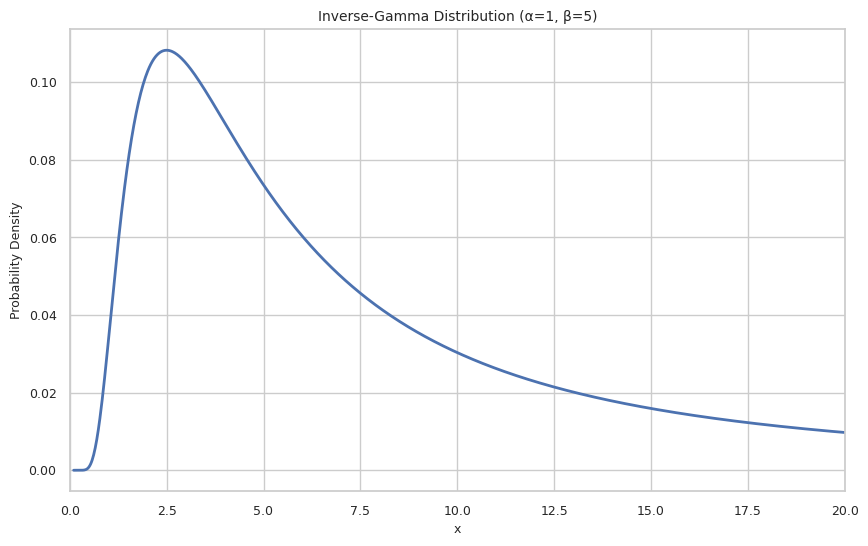

In [6]:
from scipy import stats

# Parameters for the inverse-gamma distribution
alpha = 1  # shape parameter
beta = 5   # scale parameter

# Generate x values
x_vals = np.linspace(0.1, 20, 1000)  # avoiding x=0 as PDF is undefined there

# Calculate PDF
pdf = stats.invgamma.pdf(x_vals, alpha, scale=beta)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, pdf, 'b-', lw=2)
plt.title('Inverse-Gamma Distribution (α=1, β=5)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlim(0, 20)
plt.show()

### Generated quantities block
Finally, in the generated quantities block, we will compute the log likelihood for each data point (for model comparison) and the predicted values for the input points.

### Compiling and running the Stan program
Recall that to compile the Stan program, we use the `CmdStanModel` class from the `cmdstanpy` library. You will need to specify the path to your `.stan` file.

In [19]:
model1 = CmdStanModel(stan_file='gp.stan')



12:15:51 - cmdstanpy - INFO - compiling stan file /content/gp.stan to exe file /content/gp
INFO:cmdstanpy:compiling stan file /content/gp.stan to exe file /content/gp
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=gp.stan /content/gp
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=gp.stan --o=/content/gp.hpp /content/gp.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/gp.o /content/gp.hpp

--- Linking model ---
g++ 

TypeError: 'int' object is not callable

After compiling the model, you need to prepare the data as a dictionary and pass it to the `CmdStanModel` object's `sample` method.

In [20]:
stan_data = {'N': len(x), 'x': x, 'y': y}

Use the `sample` method to execute the inference algorithm. Run 4 chains with 500 warmup iterations and 1000 sampling iterations. Set the `adapt_delta` argument to 0.95 (for more stable sampling). Set a seed for replicability.

In [22]:
import time

start_time = time.time()

# ==========
model1_fit = model1.sample(
    data=stan_data,
    seed=123,
    chains=4,
    parallel_chains=4,
    iter_warmup=500,
    iter_sampling=1000,
    refresh=100,  # Print update every 500 iterations
    save_warmup=True,
    adapt_delta=0.95
)
# ==========

end_time = time.time()
runtime = end_time - start_time
print(f"Runtime of the Stan model: {runtime} seconds")

DEBUG:cmdstanpy:cmd: /content/gp info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoezl5nae/hwl3ejtz.json
12:18:09 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/gp', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpoezl5nae/hwl3ejtz.json', 'output', 'file=/tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_1.csv', 'refresh=100', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/gp', 'id=2', 'random', 'seed=123', 'data', 'file=/tmp/tmpoezl5nae/hwl3ejtz.json', 'output', 'file=/tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_2.csv', 'refresh=100', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/gp', 'id=3', 'random', 'seed=123', 'data', 'file=/tmp/tmpoezl5nae/hwl3ejtz.json', '

12:20:23 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/gp', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpoezl5nae/hwl3ejtz.json', 'output', 'file=/tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_1.csv', 'refresh=100', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_1.csv
 console_msgs (if any):
	/tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 500
    save_warmup = true
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.95
      kappa = 0.75 (Default)


Runtime of the Stan model: 133.57384324073792 seconds


How long did it take the inference algorithm to run?

### Posthoc model diagnostics
We should always check for issues in the sampling process and whether the MCMC chains have converged. We can use the `CmdStanMCMC` object's `diagnose` method to check for divergences, treedepth issues, and other potential problems.

In [23]:
model1_fit.diagnose()

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/diagnose /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_1.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_2.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_3.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_4.csv
cwd: None


'Checking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nRank-normalized split effective sample size satisfactory for all parameters.\n\nRank-normalized split R-hat values satisfactory for all parameters.\n\nProcessing complete, no problems detected.\n'

Use the `CmdStanMCMC` object's `summary` method to get a summary of the posterior samples. Check if there are any parameters where $\hat{R} > 1.1$ and where the `ESS_bulk` is less than 1000.

In [25]:
summary = model1_fit.summary()

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpoezl5nae/stansummary-gp-wpuwm5ji.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_1.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_2.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_3.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_4.csv
cwd: None


In [31]:
summary.loc[(summary['R_hat']>1.1)&(summary['ESS_bulk']<1000)]

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat


### Posterior analysis

Use the `from_cmdstanpy` function in Arviz to convert the fit object into an inference data object.

In [32]:
# Convert the CmdStanPy model fit to ArviZ InferenceData
model1_fit_az_idata = az.from_cmdstanpy(model1_fit, save_warmup=True)

# arviz parses our data into groups based on our fit object
model1_fit_az_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

Warmup iterations saved (warmup_*).

Define a dictionary called `custom_summary_fns` that has 3 elements:
1. "median": A lambda function that calculates the median of a given sequence (50th percentile)
2. "q2.5": A lambda function that calculates the 2.5% percentile of a given sequence
3. "q97.5": A lambda function that calculates the 97.5% percentile of a given sequence

Pass this dictionary to the `stat_funcs` argument of the `summary` method to obtain the desired summary statistics for `mu`, the expected flow rate.

In [43]:
custom_summary_fns = {"median" : lambda x: np.median(x),
                      "q2.5" : lambda x: np.percentile(x, 2.5, axis=0),
                      "q97.5" : lambda x: np.percentile(x, 97.5, axis=0)}

In [50]:
summary = model1_fit.summary(percentiles=[2.5,50,97.5])

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/stansummary --percentiles= 2.5,50,97.5 --sig_figs=6 --csv_filename=/tmp/tmpoezl5nae/stansummary-gp-v2hbvlhv.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_1.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_2.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_3.csv /tmp/tmpoezl5nae/gpu73alufp/gp-20250325121809_4.csv
cwd: None


In [51]:
summary.head()

,Mean,MCSE,StdDev,MAD,2.5%,50%,97.5%,ESS_bulk,ESS_tail,R_hat
lp__,-60.229100,0.188005,7.28035,7.32145,-75.20040,-59.903400,-46.96120,1506.81,2343.31,1.00322
alpha,0.028124,0.055420,5.09777,5.04323,-9.92525,0.069858,10.17800,8729.30,2837.82,1.00030
sigma_noise,36.253600,4.777990,225.66600,7.10371,1.34763,7.508470,221.64700,3785.22,1996.36,1.00089
z[1],0.011770,0.012095,1.00153,1.03534,-1.97736,0.013608,1.93058,6999.78,2812.83,1.00093
z[2],-0.009136,0.011970,1.02925,0.99745,-2.06138,-0.016029,2.05456,7522.21,2714.98,1.00034


In [53]:
# Get summary statistics, including 2.75% and 97.5% quantiles
summary_stats = az.summary(model1_fit_az_idata,
                           group="posterior",
                           hdi_prob=0.95,
                           kind="all",# 95% highest density interval
                           stat_funcs=custom_summary_fns
                           )

summary_stats

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,q2.5,q97.5
alpha,0.028,5.098,-10.600,9.461,0.055,0.096,8729.0,2838.0,1.0,0.070,-9.925,10.178
ell,70.748,1066.390,0.568,104.842,25.082,383.709,5018.0,1991.0,1.0,6.878,1.359,197.321
f[0],7.942,283.732,-60.197,93.602,5.883,79.274,4432.0,2458.0,1.0,0.060,-65.450,89.876
f[1],7.961,284.037,-83.675,69.888,5.896,79.257,4435.0,2426.0,1.0,0.076,-65.444,91.116
f[2],7.979,284.356,-76.622,77.260,5.909,79.236,4441.0,2426.0,1.0,0.109,-65.440,91.005
...,...,...,...,...,...,...,...,...,...,...,...,...
z[95],-0.016,0.993,-1.876,1.940,0.011,0.019,8289.0,2885.0,1.0,-0.031,-1.918,1.919
z[96],-0.028,1.005,-2.074,1.856,0.012,0.018,7077.0,2646.0,1.0,-0.032,-1.986,1.997
z[97],-0.008,1.009,-2.049,1.880,0.012,0.022,6658.0,2800.0,1.0,-0.018,-1.956,2.028
z[98],0.015,1.021,-1.900,2.028,0.013,0.017,6306.0,2961.0,1.0,0.027,-1.991,1.991


Plot the posterior distribution of `mu` agains the real data

/usr/local/lib/python3.11/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


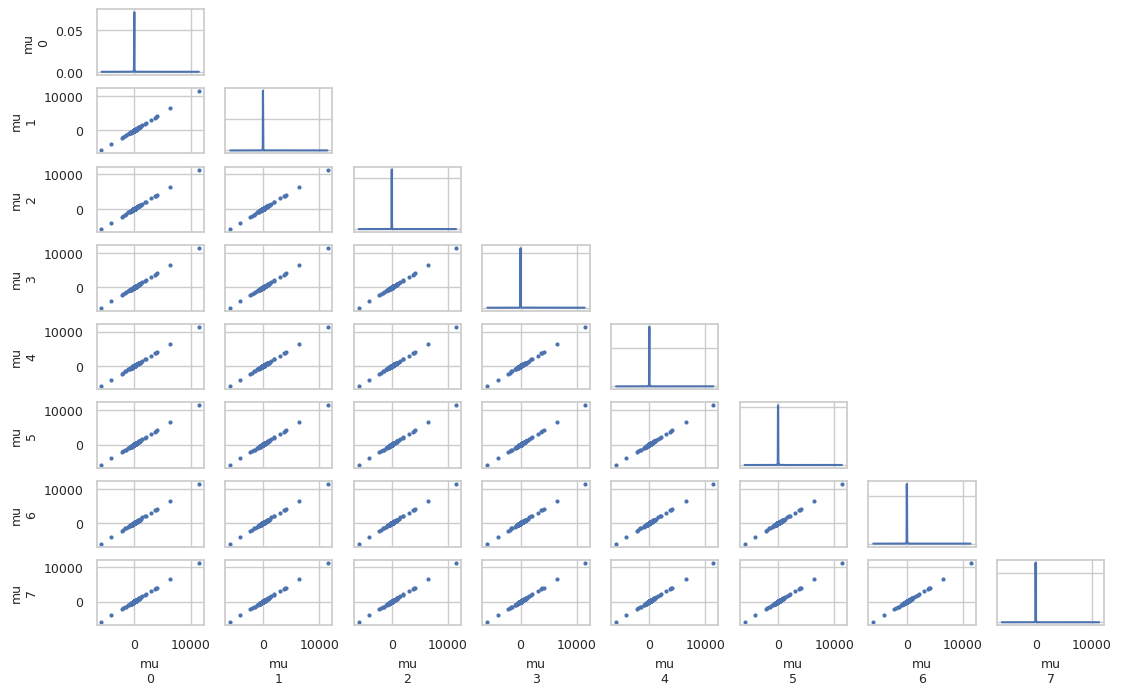

In [59]:
az.plot_pair(model1_fit_az_idata,
             var_names="mu",
             group="posterior",
             marginals=True,
             figsize=(13, 8))

plt.show()

### Posterior predictive checks
In a similar fashion to `mu`, calculate the median and the 95% credible intervals for the posterior predictive distribution. Plot this against the real data.

Calculate the proportion of data points within the 95% posterior credible interval.